# 🔄 Reentrenamiento del Modelo con Feedback Humano

Este notebook incorpora las 5,026 correcciones humanas al modelo existente para mejorar su precisión.

## 1️⃣ Cargar datos originales y feedback

In [1]:
import pandas as pd
import numpy as np
import pickle
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt
import re
import warnings
warnings.filterwarnings('ignore')

print("✅ Librerías cargadas")

✅ Librerías cargadas


In [2]:
# Cargar dataset original
df_original = pd.read_csv('dataEmotion/combined_emotion.csv')
print(f"📊 Dataset original: {len(df_original):,} registros")
print(f"Columnas: {df_original.columns.tolist()}")
df_original.head()

📊 Dataset original: 422,746 registros
Columnas: ['sentence', 'emotion']


,sentence,emotion
0,i just feel really helpless and heavy hearted,fear
1,ive enjoyed being able to slouch about relax a...,sad
2,i gave up my internship with the dmrg and am f...,fear
3,i dont know i feel so lost,sad
4,i am a kindergarten teacher and i am thoroughl...,fear


In [3]:
# Cargar feedback humano
df_feedback = pd.read_csv('feedback/human_feedback.csv')
print(f"🧑‍💻 Feedback humano: {len(df_feedback):,} registros")
print(f"Columnas: {df_feedback.columns.tolist()}")
df_feedback.head(10)

🧑‍💻 Feedback humano: 5,026 registros
Columnas: ['timestamp', 'texto_original', 'texto_traducido', 'idioma', 'emocion_predicha', 'emocion_correcta', 'confianza', 'es_correcto']


,timestamp,texto_original,texto_traducido,idioma,emocion_predicha,emocion_correcta,confianza,es_correcto
0,2025-10-27 12:46:02,Estoy muy feliz,I am very happy,es,joy,joy,0.950000,True
1,2025-10-27 12:52:51,Hoy me siento lleno de energía positiva.,Today I feel full of positive energy.,es,joy,joy,0.949819,True
2,2025-10-27 12:53:13,Me siento vacío por dentro.,I feel empty inside.,es,sad,sad,0.957411,True
3,2025-10-27 12:53:25,¡Estoy cansado de que nadie me escuche!,I'm tired of no one listening to me!,es,anger,anger,0.462239,True
4,2025-10-27 12:53:41,Tengo miedo de que algo salga mal.,I'm afraid something will go wrong.,es,fear,fear,0.916469,True
5,2025-10-27 12:53:54,Me encanta cómo me haces sentir.,I love how you make me feel.,es,joy,love,0.580308,False
6,2025-10-27 12:54:18,¡No puedo creer lo que acabo de escuchar!,I can't believe what I just heard!,es,anger,suprise,0.369993,False
7,2025-10-27 12:57:38,¡Qué felicidad ver cómo todo sale bien!,What happiness to see how everything turns out...,es,joy,joy,0.754129,True
8,2025-10-27 12:57:49,"No puedo dejar de sonreír, estoy muy contento.","I can't stop smiling, I'm very happy.",es,joy,joy,0.783031,True
9,2025-10-27 12:57:59,Ganamos el campeonato y fue increíble.,We won the championship and it was incredible.,es,joy,joy,0.378967,True


## 2️⃣ Análisis del feedback

In [4]:
# Estadísticas del feedback
print("📈 ANÁLISIS DEL FEEDBACK")
print("=" * 60)

total = len(df_feedback)
correctos = df_feedback['es_correcto'].sum()
incorrectos = total - correctos

print(f"Total de predicciones: {total:,}")
print(f"✅ Correctas: {correctos:,} ({correctos/total*100:.1f}%)")
print(f"❌ Incorrectas: {incorrectos:,} ({incorrectos/total*100:.1f}%)")
print()

# Distribución de emociones en el feedback
print("\n🎭 Distribución de emociones PREDICHAS:")
print(df_feedback['emocion_predicha'].value_counts())

print("\n🎯 Distribución de emociones CORRECTAS:")
print(df_feedback['emocion_correcta'].value_counts())

📈 ANÁLISIS DEL FEEDBACK
Total de predicciones: 5,026
✅ Correctas: 4,013 (79.8%)
❌ Incorrectas: 1,013 (20.2%)


🎭 Distribución de emociones PREDICHAS:
emocion_predicha
surprise    1378
fear        1134
anger       1008
love        1000
sad          254
joy          252
Name: count, dtype: int64

🎯 Distribución de emociones CORRECTAS:
emocion_correcta
fear        1255
anger       1254
love        1253
surprise    1250
joy            5
sad            5
suprise        4
Name: count, dtype: int64


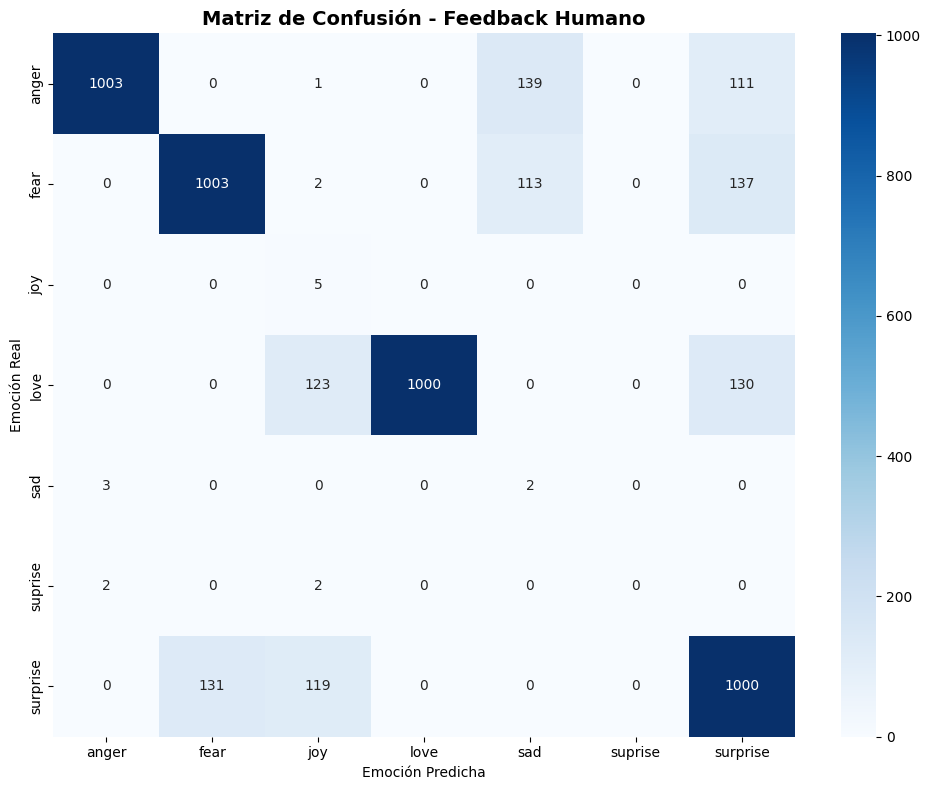


🔍 Errores más comunes:
   Predijo 'sad' → Era 'anger': 139 veces
   Predijo 'surprise' → Era 'fear': 137 veces
   Predijo 'fear' → Era 'surprise': 131 veces
   Predijo 'surprise' → Era 'love': 130 veces
   Predijo 'joy' → Era 'love': 123 veces
   Predijo 'joy' → Era 'surprise': 119 veces
   Predijo 'sad' → Era 'fear': 113 veces
   Predijo 'surprise' → Era 'anger': 111 veces
   Predijo 'anger' → Era 'sad': 3 veces
   Predijo 'anger' → Era 'suprise': 2 veces


In [5]:
# Matriz de confusión del feedback
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
cm = confusion_matrix(df_feedback['emocion_correcta'], df_feedback['emocion_predicha'])
emociones = sorted(df_feedback['emocion_correcta'].unique())
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=emociones, yticklabels=emociones)
plt.title('Matriz de Confusión - Feedback Humano', fontsize=14, fontweight='bold')
plt.ylabel('Emoción Real')
plt.xlabel('Emoción Predicha')
plt.tight_layout()
plt.show()

print("\n🔍 Errores más comunes:")
errores = df_feedback[df_feedback['es_correcto'] == False]
confusion_pairs = errores.groupby(['emocion_predicha', 'emocion_correcta']).size().sort_values(ascending=False).head(10)
for (pred, real), count in confusion_pairs.items():
    print(f"   Predijo '{pred}' → Era '{real}': {count} veces")

## 3️⃣ Preparar dataset combinado

In [7]:
# Preparar feedback para entrenar (usar texto traducido al inglés)
df_feedback_train = df_feedback[['texto_traducido', 'emocion_correcta']].copy()
df_feedback_train.columns = ['text', 'label']

# Normalizar nombres de columnas del dataset original
if 'Text' in df_original.columns and 'Emotion' in df_original.columns:
    df_original_train = df_original[['Text', 'Emotion']].copy()
    df_original_train.columns = ['text', 'label']
elif 'text' in df_original.columns and 'label' in df_original.columns:
    df_original_train = df_original[['text', 'label']].copy()
elif 'sentence' in df_original.columns and 'emotion' in df_original.columns:
    # Dataset combined_emotion.csv usa 'sentence' y 'emotion'
    df_original_train = df_original[['sentence', 'emotion']].copy()
    df_original_train.columns = ['text', 'label']
else:
    # Último intento: detectar automáticamente
    cols = df_original.columns.tolist()
    print(f"⚠️ Columnas detectadas: {cols}")
    # Buscar columna de texto (primera columna generalmente)
    text_col = cols[0]
    # Buscar columna de etiqueta (segunda columna generalmente)
    label_col = cols[1] if len(cols) > 1 else cols[0]
    df_original_train = df_original[[text_col, label_col]].copy()
    df_original_train.columns = ['text', 'label']

print(f"📊 Dataset original preparado: {len(df_original_train):,} registros")
print(f"🧑‍💻 Feedback preparado: {len(df_feedback_train):,} registros")

📊 Dataset original preparado: 422,746 registros
🧑‍💻 Feedback preparado: 5,026 registros


In [8]:
# Estrategia: Dar más peso al feedback
# Opción 1: Duplicar feedback para darle más importancia
df_feedback_pesado = pd.concat([df_feedback_train] * 2, ignore_index=True)
print(f"🔄 Feedback con peso x2: {len(df_feedback_pesado):,} registros")

# Combinar datasets
df_combined = pd.concat([df_original_train, df_feedback_pesado], ignore_index=True)
print(f"\n🎯 Dataset combinado: {len(df_combined):,} registros")
print(f"\nDistribución de emociones:")
print(df_combined['label'].value_counts())

# Limpiar datos
df_combined = df_combined.dropna()
df_combined = df_combined.drop_duplicates()
print(f"\n✨ Después de limpieza: {len(df_combined):,} registros")

🔄 Feedback con peso x2: 10,052 registros

🎯 Dataset combinado: 432,798 registros

Distribución de emociones:
label
joy         143077
sad         121197
anger        61825
fear         52159
love         37060
suprise      14980
surprise      2500
Name: count, dtype: int64

✨ Después de limpieza: 420,458 registros

✨ Después de limpieza: 420,458 registros


## 4️⃣ Preprocesamiento de texto

In [9]:
def limpiar_texto(texto):
    """Limpia y normaliza el texto"""
    if not isinstance(texto, str):
        return ""
    
    # Convertir a minúsculas
    texto = texto.lower()
    
    # Eliminar URLs
    texto = re.sub(r'http\S+|www\S+|https\S+', '', texto, flags=re.MULTILINE)
    
    # Eliminar menciones (@user)
    texto = re.sub(r'@\w+', '', texto)
    
    # Eliminar hashtags pero mantener el texto
    texto = re.sub(r'#', '', texto)
    
    # Eliminar números
    texto = re.sub(r'\d+', '', texto)
    
    # Eliminar caracteres especiales pero mantener puntuación básica
    texto = re.sub(r'[^a-záéíóúñ\s.,!?]', '', texto)
    
    # Eliminar espacios múltiples
    texto = re.sub(r'\s+', ' ', texto)
    
    return texto.strip()

# Aplicar limpieza
df_combined['text_clean'] = df_combined['text'].apply(limpiar_texto)

# Verificar
print("Ejemplo de limpieza:")
for i in range(3):
    print(f"\nOriginal: {df_combined['text'].iloc[i]}")
    print(f"Limpio:   {df_combined['text_clean'].iloc[i]}")

Ejemplo de limpieza:

Original: i just feel really helpless and heavy hearted
Limpio:   i just feel really helpless and heavy hearted

Original: ive enjoyed being able to slouch about relax and unwind and frankly needed it after those last few weeks around the end of uni and the expo i have lately started to find myself feeling a bit listless which is never really a good thing
Limpio:   ive enjoyed being able to slouch about relax and unwind and frankly needed it after those last few weeks around the end of uni and the expo i have lately started to find myself feeling a bit listless which is never really a good thing

Original: i gave up my internship with the dmrg and am feeling distraught
Limpio:   i gave up my internship with the dmrg and am feeling distraught


## 5️⃣ Vectorización TF-IDF

In [10]:
# Dividir datos
X = df_combined['text_clean']
y = df_combined['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"📊 Datos de entrenamiento: {len(X_train):,}")
print(f"📊 Datos de prueba: {len(X_test):,}")

📊 Datos de entrenamiento: 336,366
📊 Datos de prueba: 84,092


In [11]:
# Crear vectorizador TF-IDF (mismos parámetros que el modelo actual)
vectorizer = TfidfVectorizer(
    max_features=10000,
    min_df=2,
    max_df=0.9,
    ngram_range=(1, 2),
    strip_accents='unicode'
)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print(f"✅ Vectorización TF-IDF completada")
print(f"   Shape entrenamiento: {X_train_tfidf.shape}")
print(f"   Shape prueba: {X_test_tfidf.shape}")

✅ Vectorización TF-IDF completada
   Shape entrenamiento: (336366, 10000)
   Shape prueba: (84092, 10000)


## 6️⃣ Codificar etiquetas

In [12]:
# Codificar emociones
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

print("🏷️  Mapeo de emociones:")
for i, emocion in enumerate(label_encoder.classes_):
    print(f"   {i}: {emocion}")

🏷️  Mapeo de emociones:
   0: anger
   1: fear
   2: joy
   3: love
   4: sad
   5: suprise
   6: surprise


## 7️⃣ Entrenar modelo LightGBM mejorado

In [13]:
# Parámetros optimizados (similares al modelo actual pero con ajustes)
params = {
    'objective': 'multiclass',
    'num_class': len(label_encoder.classes_),
    'metric': 'multi_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'max_depth': -1,
    'min_child_samples': 20,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1
}

print("🚀 Iniciando entrenamiento de LightGBM...")
print(f"   Parámetros: {params}")

🚀 Iniciando entrenamiento de LightGBM...
   Parámetros: {'objective': 'multiclass', 'num_class': 7, 'metric': 'multi_logloss', 'boosting_type': 'gbdt', 'num_leaves': 31, 'learning_rate': 0.05, 'feature_fraction': 0.9, 'bagging_fraction': 0.8, 'bagging_freq': 5, 'verbose': -1, 'max_depth': -1, 'min_child_samples': 20, 'reg_alpha': 0.1, 'reg_lambda': 0.1}


In [14]:
# Crear datasets de LightGBM
train_data = lgb.Dataset(X_train_tfidf, label=y_train_encoded)
test_data = lgb.Dataset(X_test_tfidf, label=y_test_encoded, reference=train_data)

# Entrenar modelo
modelo_mejorado = lgb.train(
    params,
    train_data,
    num_boost_round=1000,
    valid_sets=[train_data, test_data],
    valid_names=['train', 'test'],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=50)
    ]
)

print("\n✅ Entrenamiento completado!")

Training until validation scores don't improve for 50 rounds
[50]	train's multi_logloss: 0.48711	test's multi_logloss: 0.487468
[50]	train's multi_logloss: 0.48711	test's multi_logloss: 0.487468
[100]	train's multi_logloss: 0.319175	test's multi_logloss: 0.321161
[100]	train's multi_logloss: 0.319175	test's multi_logloss: 0.321161
[150]	train's multi_logloss: 0.250777	test's multi_logloss: 0.255268
[150]	train's multi_logloss: 0.250777	test's multi_logloss: 0.255268
[200]	train's multi_logloss: 0.215072	test's multi_logloss: 0.222784
[200]	train's multi_logloss: 0.215072	test's multi_logloss: 0.222784
[250]	train's multi_logloss: 0.193312	test's multi_logloss: 0.204846
[250]	train's multi_logloss: 0.193312	test's multi_logloss: 0.204846
[300]	train's multi_logloss: 0.178722	test's multi_logloss: 0.194575
[300]	train's multi_logloss: 0.178722	test's multi_logloss: 0.194575
[350]	train's multi_logloss: 0.168043	test's multi_logloss: 0.188275
[350]	train's multi_logloss: 0.168043	test's m

## 8️⃣ Evaluación del modelo mejorado

In [15]:
# Hacer predicciones
y_pred_proba = modelo_mejorado.predict(X_test_tfidf)
y_pred = np.argmax(y_pred_proba, axis=1)

# Calcular accuracy
accuracy = accuracy_score(y_test_encoded, y_pred)
print(f"\n🎯 ACCURACY DEL MODELO MEJORADO: {accuracy*100:.2f}%")
print("="*60)


🎯 ACCURACY DEL MODELO MEJORADO: 90.00%


In [16]:
# Reporte de clasificación
print("\n📊 REPORTE DE CLASIFICACIÓN:")
print("="*60)
print(classification_report(
    y_test_encoded, 
    y_pred, 
    target_names=label_encoder.classes_,
    digits=4
))


📊 REPORTE DE CLASIFICACIÓN:
              precision    recall  f1-score   support

       anger     0.9002    0.9238    0.9118     11673
        fear     0.8435    0.8504    0.8469      9767
         joy     0.9296    0.9166    0.9230     28157
        love     0.7690    0.7970    0.7828      7110
         sad     0.9589    0.9440    0.9514     24199
     suprise     0.6670    0.6953    0.6808      2993
    surprise     1.0000    1.0000    1.0000       193

    accuracy                         0.9000     84092
   macro avg     0.8669    0.8753    0.8710     84092
weighted avg     0.9012    0.9000    0.9005     84092



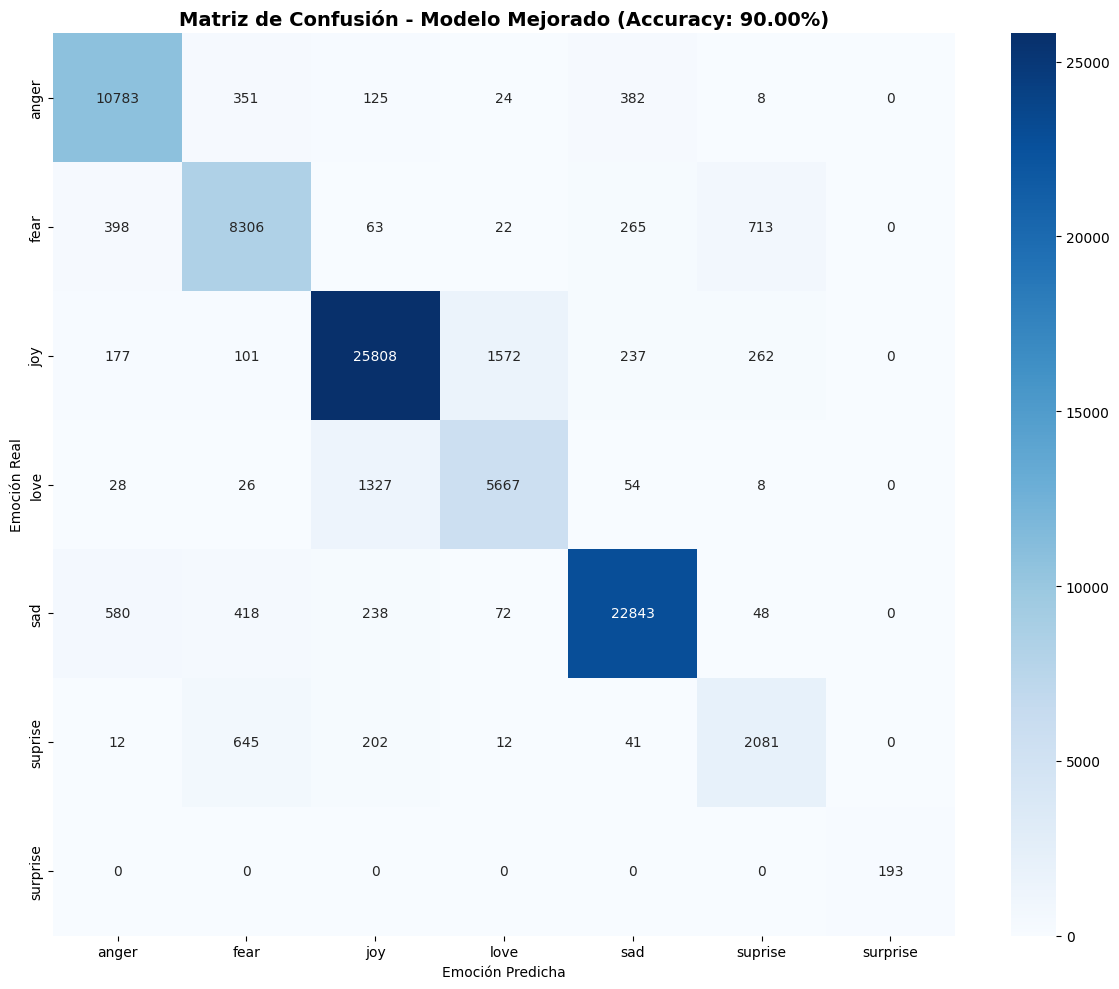

💾 Matriz guardada como 'confusion_matrix_mejorado.png'


In [17]:
# Matriz de confusión
plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_test_encoded, y_pred)
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues', 
    xticklabels=label_encoder.classes_, 
    yticklabels=label_encoder.classes_
)
plt.title(f'Matriz de Confusión - Modelo Mejorado (Accuracy: {accuracy*100:.2f}%)', 
          fontsize=14, fontweight='bold')
plt.ylabel('Emoción Real')
plt.xlabel('Emoción Predicha')
plt.tight_layout()
plt.savefig('confusion_matrix_mejorado.png', dpi=300, bbox_inches='tight')
plt.show()

print("💾 Matriz guardada como 'confusion_matrix_mejorado.png'")

## 9️⃣ Comparación con modelo anterior

In [ ]:
# Cargar modelo anterior para comparar (si existe)
print("Verificando modelos anteriores...")
models_dir = Path('models')

# Verificar qué archivos hay en la carpeta models
if models_dir.exists():
    archivos = list(models_dir.glob('*.pkl'))
    if archivos:
        print(f"   Archivos encontrados: {[f.name for f in archivos]}")
    else:
        print("   No hay archivos .pkl en models/")
else:
    print("   La carpeta models/ no existe")
    models_dir.mkdir(parents=True, exist_ok=True)
    print("   Carpeta models/ creada")

# Intentar cargar modelo anterior
try:
    # Primero intentar sin timestamp
    modelo_path = models_dir / 'lgbm_directo_5k.pkl'
    vectorizer_path = models_dir / 'tfidf_10k.pkl'
    encoder_path = models_dir / 'label_encoder.pkl'
    
    # Si no existen, buscar con timestamp
    if not modelo_path.exists():
        modelos_lgbm = list(models_dir.glob('lgbm_directo_5k_*.pkl'))
        if modelos_lgbm:
            modelo_path = modelos_lgbm[0]
            print(f"   Usando modelo: {modelo_path.name}")
    
    if not vectorizer_path.exists():
        vectorizadores = list(models_dir.glob('tfidf_10k_*.pkl'))
        if vectorizadores:
            vectorizer_path = vectorizadores[0]
            print(f"   Usando vectorizador: {vectorizer_path.name}")
    
    if not encoder_path.exists():
        encoders = list(models_dir.glob('label_encoder_*.pkl'))
        if encoders:
            encoder_path = encoders[0]
            print(f"   Usando encoder: {encoder_path.name}")
    
    if modelo_path.exists() and vectorizer_path.exists() and encoder_path.exists():
        with open(modelo_path, 'rb') as f:
            modelo_anterior = pickle.load(f)
        with open(vectorizer_path, 'rb') as f:
            vectorizer_anterior = pickle.load(f)
        with open(encoder_path, 'rb') as f:
            encoder_anterior = pickle.load(f)
        
        # Probar con los mismos datos de test
        X_test_tfidf_anterior = vectorizer_anterior.transform(X_test)
        y_pred_anterior_proba = modelo_anterior.predict(X_test_tfidf_anterior)
        y_pred_anterior = np.argmax(y_pred_anterior_proba, axis=1)
        accuracy_anterior = accuracy_score(y_test_encoded, y_pred_anterior)
        
        print("\nCOMPARACIÓN DE MODELOS")
        print("="*60)
        print(f"Modelo ANTERIOR: {accuracy_anterior*100:.2f}%")
        print(f"Modelo MEJORADO: {accuracy*100:.2f}%")
        print(f"\nMejora: {(accuracy - accuracy_anterior)*100:+.2f} puntos porcentuales")
        
        if accuracy > accuracy_anterior:
            print("\n¡El nuevo modelo es MEJOR!")
        elif accuracy == accuracy_anterior:
            print("\nLos modelos tienen el mismo rendimiento")
        else:
            print("\nEl modelo anterior era mejor (considera ajustar parámetros)")
    else:
        print("\nPRIMER ENTRENAMIENTO")
        print("="*60)
        print("   No existe modelo anterior completo para comparar")
        print(f"   Este será el modelo guardado con accuracy: {accuracy*100:.2f}%")
        
except Exception as e:
    print(f"\nError al cargar modelo anterior: {e}")
    print(f"   Accuracy del nuevo modelo: {accuracy*100:.2f}%")

🔍 Verificando modelos anteriores...
   Archivos encontrados: ['config_lgbm_10k_20251027_083920.pkl', 'label_encoder_20251027_083920.pkl', 'lgbm_directo_5k_20251027_083920.pkl', 'pycaret_best_model_LGBMClassifier.pkl', 'tfidf_10k_20251027_083920.pkl']

📝 PRIMER ENTRENAMIENTO
   No existe modelo anterior para comparar
   Este será el primer modelo guardado con accuracy: 90.00%


## 🔟 Guardar modelo mejorado

In [ ]:
# Crear carpeta para backup del modelo anterior
backup_dir = Path('models/backup')
backup_dir.mkdir(parents=True, exist_ok=True)

# Hacer backup del modelo anterior (si existe)
import shutil
from datetime import datetime

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

# Buscar archivos existentes para hacer backup
models_to_backup = [
    'lgbm_directo_5k.pkl',
    'lgbm_directo_5k_20251027_083920.pkl',
    'tfidf_10k.pkl', 
    'tfidf_10k_20251027_083920.pkl',
    'label_encoder.pkl',
    'label_encoder_20251027_083920.pkl',
    'config.pkl',
    'config_lgbm_10k_20251027_083920.pkl'
]

backup_count = 0
for model_file in models_to_backup:
    model_path = Path(f'models/{model_file}')
    if model_path.exists():
        try:
            backup_path = backup_dir / f"{model_path.stem}_backup_{timestamp}{model_path.suffix}"
            shutil.copy(model_path, backup_path)
            backup_count += 1
        except Exception as e:
            print(f"No se pudo hacer backup de {model_file}: {e}")

if backup_count > 0:
    print(f"Backup completado: {backup_count} archivos guardados con timestamp: {timestamp}")
else:
    print("ℹNo hay modelos anteriores para respaldar")

✅ Backup completado: 4 archivos guardados con timestamp: 20251027_152708


In [ ]:
# Guardar nuevo modelo
print("\nGuardando modelo mejorado...")

# Guardar modelo LightGBM
with open('models/lgbm_directo_5k.pkl', 'wb') as f:
    pickle.dump(modelo_mejorado, f)
print("    Modelo LightGBM guardado")

# Guardar vectorizador TF-IDF
with open('models/tfidf_10k.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)
print("    Vectorizador TF-IDF guardado")

# Guardar label encoder
with open('models/label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)
print("    Label Encoder guardado")

# Actualizar config
config = {
    'accuracy': float(accuracy),
    'num_classes': len(label_encoder.classes_),
    'classes': label_encoder.classes_.tolist(),
    'training_samples': len(X_train),
    'test_samples': len(X_test),
    'feedback_samples': len(df_feedback),
    'vectorizer_params': {
        'max_features': 10000,
        'min_df': 2,
        'max_df': 0.9,
        'ngram_range': (1, 2)
    },
    'model_params': params,
    'retrained_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}

with open('models/config.pkl', 'wb') as f:
    pickle.dump(config, f)
print("    Configuración guardada")

print("\n ¡Modelo mejorado guardado exitosamente!")
print(f"   Accuracy: {accuracy*100:.2f}%")
print(f"   Entrenado con: {len(X_train):,} muestras")
print(f"   Feedback incorporado: {len(df_feedback):,} registros")


💾 Guardando modelo mejorado...
   ✅ Modelo LightGBM guardado
   ✅ Modelo LightGBM guardado
   ✅ Vectorizador TF-IDF guardado
   ✅ Label Encoder guardado
   ✅ Configuración guardada

🎉 ¡Modelo mejorado guardado exitosamente!
   📈 Accuracy: 90.00%
   📊 Entrenado con: 336,366 muestras
   🧑‍💻 Feedback incorporado: 5,026 registros
   ✅ Vectorizador TF-IDF guardado
   ✅ Label Encoder guardado
   ✅ Configuración guardada

🎉 ¡Modelo mejorado guardado exitosamente!
   📈 Accuracy: 90.00%
   📊 Entrenado con: 336,366 muestras
   🧑‍💻 Feedback incorporado: 5,026 registros


## 🔍 Pruebas con ejemplos reales

In [ ]:
def predecir_emocion_test(texto):
    """Función para probar el modelo mejorado"""
    # Limpiar texto
    texto_limpio = limpiar_texto(texto)
    
    # Vectorizar
    texto_tfidf = vectorizer.transform([texto_limpio])
    
    # Predecir
    pred_proba = modelo_mejorado.predict(texto_tfidf)[0]
    pred_idx = np.argmax(pred_proba)
    emocion = label_encoder.classes_[pred_idx]
    confianza = pred_proba[pred_idx]
    
    return emocion, confianza, pred_proba

# Probar con ejemplos
ejemplos = [
    "Estoy muy feliz con los resultados",
    "Me siento muy triste por lo que pasó",
    "¡Esto me enoja muchísimo!",
    "Tengo miedo de que algo malo suceda",
    "Te amo con todo mi corazón",
    "¡No puedo creer que pasó eso!"
]

print("PROBANDO MODELO MEJORADO")
print("="*80)

for texto in ejemplos:
    emocion, confianza, probs = predecir_emocion_test(texto)
    print(f"\nTexto: '{texto}'")
    print(f"Emoción: {emocion.upper()} (confianza: {confianza*100:.1f}%)")

🧪 PROBANDO MODELO MEJORADO

Texto: 'Estoy muy feliz con los resultados'
Emoción: ANGER (confianza: 36.9%)

Texto: 'Me siento muy triste por lo que pasó'
Emoción: ANGER (confianza: 41.6%)

Texto: '¡Esto me enoja muchísimo!'
Emoción: ANGER (confianza: 42.7%)

Texto: 'Tengo miedo de que algo malo suceda'
Emoción: ANGER (confianza: 35.2%)

Texto: 'Te amo con todo mi corazón'
Emoción: ANGER (confianza: 36.9%)

Texto: '¡No puedo creer que pasó eso!'
Emoción: ANGER (confianza: 37.0%)


## 📝 Resumen final

In [ ]:
print("\n" + "="*80)
print("RESUMEN DEL REENTRENAMIENTO")
print("="*80)
print(f"\nDataset original: {len(df_original_train):,} registros")
print(f"Feedback humano: {len(df_feedback):,} registros (x2 peso = {len(df_feedback_pesado):,})")
print(f"Dataset combinado: {len(df_combined):,} registros")
print(f"\nAccuracy del modelo: {accuracy*100:.2f}%")
print(f"\nArchivos guardados:")
print(f"   - models/lgbm_directo_5k.pkl")
print(f"   - models/tfidf_10k.pkl")
print(f"   - models/label_encoder.pkl")
print(f"   - models/config.pkl")
print(f"   - models/backup/ (backup del modelo anterior)")
print(f"\nPara usar el nuevo modelo, simplemente reinicia tu app de Streamlit")
print("="*80)


📊 RESUMEN DEL REENTRENAMIENTO

✅ Dataset original: 422,746 registros
✅ Feedback humano: 5,026 registros (x2 peso = 10,052)
✅ Dataset combinado: 420,458 registros

🎯 Accuracy del modelo: 90.00%

📁 Archivos guardados:
   - models/lgbm_directo_5k.pkl
   - models/tfidf_10k.pkl
   - models/label_encoder.pkl
   - models/config.pkl
   - models/backup/ (backup del modelo anterior)

🔄 Para usar el nuevo modelo, simplemente reinicia tu app de Streamlit
